In [1]:
from typing import List
from functools import partial
import os

import numpy as np
from matplotlib import pyplot as plt
import cirq
from cirq import(
    I,
    Circuit,
    NoiseModel,
    DensityMatrixSimulator,
    BitFlipChannel,
    PhaseFlipChannel,
    measure,

)

from mitiq import zne
from mitiq.benchmarks import generate_rb_circuits
from mitiq.zne.scaling import fold_global

In [52]:
import os 
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2023/bin/universal-darwin/man/man1/latex.1' 
import subprocess
subprocess.check_call(["latex"])

NotADirectoryError: [Errno 20] Not a directory: 'latex'

In [3]:
def execute(circuit, shots, correct_bitstring):
    """Executes the input circuit(s) and returns ⟨A⟩, where
    A = |correct_bitstring⟩⟨correct_bitstring| for each circuit.
    """
    circuit_to_run = circuit.copy()

    circuit_to_run += measure(*sorted(circuit.all_qubits()), key="m")
    backend = DensityMatrixSimulator()

    result = backend.run(circuit_to_run, repetitions=shots)
    expval = result.measurements["m"].tolist().count(correct_bitstring) / shots
    return expval

Pauli errors are applied with probability of the logcial error rate, which is related to the code distance by $$L_{ERR}=0.03*(P_{ERR}/P_{TH})^{(D+1)/2}$$

where $P_{ERR}$ is the physical error rate and $P_{TH}$ is a threshold error rate.

In [2]:
def gen_noise_model(PERR, distance):
    """Create sweepable Pauli noise model."""
    PTH = 0.009
    LERR = 0.03 * (PERR / PTH) ** int((distance + 1) / 2)
    return LERR # model as single-qubit errors remaining after correction 


class PauliNoiseModel(NoiseModel):

    def __init__(self, error_rate):
        self.error_rate = error_rate

    def noisy_operation(self, op):
        error_rate = self.error_rate
        channel = BitFlipChannel(error_rate).on_each(op.qubits)
        channel += PhaseFlipChannel(error_rate).on_each(op.qubits)
        return [op, channel]

In [5]:
def merge_func(op1, op2):
    return True

In [5]:
def noisy_execute(circ, noise_level, shots, correct_bitstring):
    qubits = circ.all_qubits()
    copy = Circuit()
    for moment in circ.moments:
        idle = False
        for q in qubits:
            # every moment every qubit gets a single-qubit noise op
            if not moment.operates_on_single_qubit(q):
                idle = True
                op_to_circ = Circuit(PauliNoiseModel(noise_level).noisy_operation(cirq.I(q)))
                merged_op = cirq.merge_operations_to_circuit_op(op_to_circ, merge_func)
                copy.append(moment.with_operations(merged_op.all_operations()))
                break
        if not idle:
            copy.append(moment)
    noisy_circ = copy.with_noise(PauliNoiseModel(noise_level))
    return execute(noisy_circ, shots=shots, correct_bitstring=correct_bitstring)

In [6]:
def distance_scaled_execute(circ, distance, base_noise_level, shots, correct_bitstring):
    LERR = gen_noise_model(base_noise_level, distance)
    return noisy_execute(circ, LERR, shots, correct_bitstring)

In [3]:
def distance_extrapolation(distance_scale_factors, ds_expectation_values):
    fac = zne.PolyFactory(scale_factors=distance_scale_factors, order=3)
    for s, v in zip(distance_scale_factors, ds_expectation_values):
        fac.push({"scale_factor": s}, v)
    result = fac.reduce()
    # _ = fac.plot_fit()
    return result

In [12]:
def scale_shots(num_device_qubits, scaled_distance, base_shots, n_qubits_circuit):
    used_qubits = n_qubits_circuit * scaled_distance ** 2
    return base_shots * int(num_device_qubits / used_qubits)

In [4]:
num_trials = 100

base_shots = 10000
device_size = 1200
p_err=0.006
n_qubits = 2
correct_bitstring = [0] * n_qubits
depth = 20

scale_factors = [1, 3, 5, 7]
fac = zne.PolyFactory(scale_factors, order=3)

d_array = [21, 19, 17, 15, 13, 11, 9, 7, 5, 3]

In [ ]:
circuits = generate_rb_circuits(n_qubits, depth, trials=num_trials)
trial_results = np.zeros((num_trials, 5, len(d_array) - 3)) # row: trial, column: scaling technique, page: distance (high to low)

for d_ind in range(len(d_array) - 3):
    print(f"On distance {d_array[d_ind]}") 
    for trial in range(num_trials):
        if trial in np.linspace(0, num_trials, 11):
            print(f"    On trial {trial}")  
        executor = partial(distance_scaled_execute, distance=d_array[d_ind], base_noise_level=p_err, shots=scale_shots(device_size, d_array[d_ind], base_shots, n_qubits), correct_bitstring=correct_bitstring)
        fac.run(circuits[trial], executor, scale_noise=fold_global)
        trial_results[trial, :-1, d_ind] = fac.get_expectation_values()
        trial_results[trial, -1, d_ind] = distance_scaled_execute(circuits[trial], d_array[d_ind], p_err, 4 * scale_shots(device_size, d_array[d_ind], base_shots, n_qubits), correct_bitstring)
    p_err_string = str(p_err).replace(".", "")[1:]
    np.savetxt(os.path.join(
                f"/Users/mistywahl/Documents/GitHub/zne-distance-scaling/notebooks/data_scale_shots_perr_{p_err_string}",
                f"depth{depth}_distance{d_array[d_ind]}.txt",
            ),
            trial_results[:, :, d_ind],
        )

In [ ]:
unscaled_results = np.zeros((num_trials, 2, 3))
result_ind = 0
for d_ind in range(len(d_array) - 3, len(d_array)):
    print(f"On distance {d_array[d_ind]}") 
    for trial in range(num_trials):
        if trial in np.linspace(0, num_trials, 11):
            print(f"   On trial {trial}") 
        unscaled_results[trial, 0, result_ind] = distance_scaled_execute(circuits[trial], d_array[d_ind], base_noise_level=p_err, shots=scale_shots(device_size, d_array[d_ind], base_shots, n_qubits), correct_bitstring=correct_bitstring)
        unscaled_results[trial, 1, result_ind] = distance_scaled_execute(circuits[trial], d_array[d_ind], base_noise_level=p_err, shots=4 * scale_shots(device_size, d_array[d_ind], base_shots, n_qubits), correct_bitstring=correct_bitstring)
    p_err_string = str(p_err).replace(".", "")[1:]
    np.savetxt(os.path.join(
                f"/Users/mistywahl/Documents/GitHub/zne-distance-scaling/notebooks/data_scale_shots_perr_{p_err_string}",
                f"depth{depth}_distance{d_array[d_ind]}.txt",
            ),
            unscaled_results[:, :, result_ind],
        )
    result_ind += 1

In [6]:
ideal_values = 1 * np.ones((num_trials, 1))

p_err_string = str(p_err).replace(".", "")[1:]
exp_vals_depth20_d21 = np.loadtxt(os.path.join("./ieee-quantum-week/ds_zne/data", f"depth{depth}_distance21.txt"))
exp_vals_depth20_d19 = np.loadtxt(os.path.join("./ieee-quantum-week/ds_zne/data", f"depth{depth}_distance19.txt"))
exp_vals_depth20_d17 = np.loadtxt(os.path.join("./ieee-quantum-week/ds_zne/data", f"depth{depth}_distance17.txt"))
exp_vals_depth20_d15 = np.loadtxt(os.path.join("./ieee-quantum-week/ds_zne/data", f"depth{depth}_distance15.txt"))
exp_vals_depth20_d13 = np.loadtxt(os.path.join("./ieee-quantum-week/ds_zne/data", f"depth{depth}_distance13.txt"))
exp_vals_depth20_d11 = np.loadtxt(os.path.join("./ieee-quantum-week/ds_zne/data", f"depth{depth}_distance11.txt"))
exp_vals_depth20_d9 = np.loadtxt(os.path.join("./ieee-quantum-week/ds_zne/data", f"depth{depth}_distance9.txt"))
exp_vals_depth20_d7 = np.loadtxt(os.path.join("./ieee-quantum-week/ds_zne/data", f"depth{depth}_distance7.txt"))
exp_vals_depth20_d5 = np.loadtxt(os.path.join("./ieee-quantum-week/ds_zne/data", f"depth{depth}_distance5.txt"))

folding_value_depth20_d21 = np.zeros((num_trials, 1))
folding_value_depth20_d19 = np.zeros((num_trials, 1))
folding_value_depth20_d17 = np.zeros((num_trials, 1)) 
folding_value_depth20_d15 = np.zeros((num_trials, 1))
folding_value_depth20_d13 = np.zeros((num_trials, 1))
folding_value_depth20_d11 = np.zeros((num_trials, 1))


for trial in range(num_trials):
    folding_value_depth20_d21[trial] = fac.extrapolate(scale_factors, exp_vals_depth20_d21[trial, : -1], order=3)
    folding_value_depth20_d19[trial] = fac.extrapolate(scale_factors, exp_vals_depth20_d19[trial, : -1], order=3)
    folding_value_depth20_d17[trial] = fac.extrapolate(scale_factors, exp_vals_depth20_d17[trial, : -1], order=3)
    folding_value_depth20_d15[trial] = fac.extrapolate(scale_factors, exp_vals_depth20_d15[trial, : -1], order=3)
    folding_value_depth20_d13[trial] = fac.extrapolate(scale_factors, exp_vals_depth20_d13[trial, : -1], order=3)
    folding_value_depth20_d11[trial] = fac.extrapolate(scale_factors, exp_vals_depth20_d11[trial, : -1], order=3)


folding_mean_exp_val_depth20_d21 = np.mean(folding_value_depth20_d21)
folding_std_exp_val_depth20_d21 = np.std(folding_value_depth20_d21)
folding_error_depth20_d21 = ideal_values - folding_value_depth20_d21

folding_mean_exp_val_depth20_d19 = np.mean(folding_value_depth20_d19)
folding_std_exp_val_depth20_d19 = np.std(folding_value_depth20_d19)
folding_error_depth20_d19 = ideal_values - folding_value_depth20_d19

folding_mean_exp_val_depth20_d17 = np.mean(folding_value_depth20_d17)
folding_std_exp_val_depth20_d17 = np.std(folding_value_depth20_d17)
folding_error_depth20_d17 = ideal_values - folding_value_depth20_d17

folding_mean_exp_val_depth20_d15 = np.mean(folding_value_depth20_d15)
folding_std_exp_val_depth20_d15 = np.std(folding_value_depth20_d15)
folding_error_depth20_d15 = ideal_values - folding_value_depth20_d15

folding_mean_exp_val_depth20_d13 = np.mean(folding_value_depth20_d13)
folding_std_exp_val_depth20_d13 = np.std(folding_value_depth20_d13)
folding_error_depth20_d13 = ideal_values - folding_value_depth20_d13

folding_mean_exp_val_depth20_d11 = np.mean(folding_value_depth20_d11)
folding_std_exp_val_depth20_d11 = np.std(folding_value_depth20_d11)
folding_error_depth20_d11 = ideal_values - folding_value_depth20_d11

In [46]:
# LaTeX setup
plt.rcParams['text.latex.preamble'] = [r'\usepackage{mathptmx}']  
plt.rcParams['font.family'] = 'serif'  
plt.rcParams['text.usetex'] = True

/var/folders/mc/x5spc52d2nq_q5x2xpg3r77m0000gn/T/ipykernel_1282/4114548968.py:2: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{mathptmx}']


WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


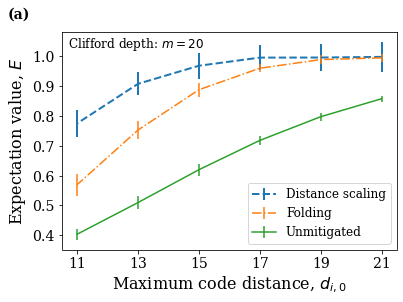

In [9]:
distance_indices = [[0, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6], [4, 5, 6, 7], [5, 6, 7, 8]]
ds_value_depth20_d21 = np.zeros((num_trials, 1)) 
ds_value_depth20_d19 = np.zeros((num_trials, 1))
ds_value_depth20_d17 = np.zeros((num_trials, 1))
ds_value_depth20_d15 = np.zeros((num_trials, 1))
ds_value_depth20_d13 = np.zeros((num_trials, 1))
ds_value_depth20_d11 = np.zeros((num_trials, 1))

distance_scale_factors = [gen_noise_model(p_err, d_array[d]) / gen_noise_model(p_err, d_array[distance_indices[0][0]]) for d in distance_indices[0]]

for trial in range(num_trials):

    ds_value_depth20_d21[trial] = distance_extrapolation(distance_scale_factors, [exp_vals_depth20_d21[trial, 0], exp_vals_depth20_d19[trial, 0], exp_vals_depth20_d17[trial, 0], exp_vals_depth20_d15[trial, 0]])
    ds_value_depth20_d19[trial] = distance_extrapolation(distance_scale_factors, [exp_vals_depth20_d19[trial, 0], exp_vals_depth20_d17[trial, 0], exp_vals_depth20_d15[trial, 0], exp_vals_depth20_d13[trial, 0]])
    ds_value_depth20_d17[trial] = distance_extrapolation(distance_scale_factors, [exp_vals_depth20_d17[trial, 0], exp_vals_depth20_d15[trial, 0], exp_vals_depth20_d13[trial, 0], exp_vals_depth20_d11[trial, 0]])
    ds_value_depth20_d15[trial] = distance_extrapolation(distance_scale_factors, [exp_vals_depth20_d15[trial, 0], exp_vals_depth20_d13[trial, 0], exp_vals_depth20_d11[trial, 0], exp_vals_depth20_d9[trial, 0]])
    ds_value_depth20_d13[trial] = distance_extrapolation(distance_scale_factors, [exp_vals_depth20_d13[trial, 0], exp_vals_depth20_d11[trial, 0], exp_vals_depth20_d9[trial, 0], exp_vals_depth20_d7[trial, 0]])
    ds_value_depth20_d11[trial] = distance_extrapolation(distance_scale_factors, [exp_vals_depth20_d11[trial, 0], exp_vals_depth20_d9[trial, 0], exp_vals_depth20_d7[trial, 0], exp_vals_depth20_d5[trial, 0]])


ds_mean_exp_val_depth20_d21 = np.mean(ds_value_depth20_d21)
ds_std_exp_val_depth20_d21 = np.std(ds_value_depth20_d21)
ds_error_depth20_d21 = ideal_values - ds_value_depth20_d21

ds_mean_exp_val_depth20_d19 = np.mean(ds_value_depth20_d19)
ds_std_exp_val_depth20_d19 = np.std(ds_value_depth20_d19)
ds_error_depth20_d19 = ideal_values - ds_value_depth20_d19

ds_mean_exp_val_depth20_d17 = np.mean(ds_value_depth20_d17)
ds_std_exp_val_depth20_d17 = np.std(ds_value_depth20_d17)
ds_error_depth20_d17 = ideal_values - ds_value_depth20_d17

ds_mean_exp_val_depth20_d15 = np.mean(ds_value_depth20_d15)
ds_std_exp_val_depth20_d15 = np.std(ds_value_depth20_d15)
ds_error_depth20_d15 = ideal_values - ds_value_depth20_d15

ds_mean_exp_val_depth20_d13 = np.mean(ds_value_depth20_d13)
ds_std_exp_val_depth20_d13 = np.std(ds_value_depth20_d13)
ds_error_depth20_d13 = ideal_values - ds_value_depth20_d13

ds_mean_exp_val_depth20_d11 = np.mean(ds_value_depth20_d11)
ds_std_exp_val_depth20_d11 = np.std(ds_value_depth20_d11)
ds_error_depth20_d11 = ideal_values - ds_value_depth20_d11

## Plot of expectation values for each set of distances
plt.errorbar(d_array[0:6], [ds_mean_exp_val_depth20_d21, ds_mean_exp_val_depth20_d19, ds_mean_exp_val_depth20_d17, ds_mean_exp_val_depth20_d15, ds_mean_exp_val_depth20_d13, ds_mean_exp_val_depth20_d11], yerr=[ds_std_exp_val_depth20_d21, ds_std_exp_val_depth20_d19, ds_std_exp_val_depth20_d17, ds_std_exp_val_depth20_d15, ds_std_exp_val_depth20_d13, ds_std_exp_val_depth20_d11], ls='--', label='Distance scaling', lw=2)
plt.errorbar(d_array[0:6], [folding_mean_exp_val_depth20_d21, folding_mean_exp_val_depth20_d19, folding_mean_exp_val_depth20_d17, folding_mean_exp_val_depth20_d15, folding_mean_exp_val_depth20_d13, folding_mean_exp_val_depth20_d11], yerr=[folding_std_exp_val_depth20_d21, folding_std_exp_val_depth20_d19, folding_std_exp_val_depth20_d17, folding_std_exp_val_depth20_d15, folding_std_exp_val_depth20_d13, folding_std_exp_val_depth20_d11], ls = '-.',label='Folding')
plt.errorbar(d_array[0:6], [np.mean(exp_vals_depth20_d21[:, 4]), np.mean(exp_vals_depth20_d19[:, 4]), np.mean(exp_vals_depth20_d17[:, 4]), np.mean(exp_vals_depth20_d15[:, 4]), np.mean(exp_vals_depth20_d13[:, 4]), np.mean(exp_vals_depth20_d11[:, 4])], yerr=[ np.std(exp_vals_depth20_d21[:, 4]), np.std(exp_vals_depth20_d19[:, 4]), np.std(exp_vals_depth20_d17[:, 4]), np.std(exp_vals_depth20_d15[:, 4]), np.std(exp_vals_depth20_d13[:, 4]), np.std(exp_vals_depth20_d11[:, 4])], label='Unmitigated')

import matplotlib.font_manager as font_manager
font = font_manager.FontProperties(family='serif', style='normal', size=12)
plt.xlabel(r'Maximum code distance, $d_{i,0}$', family='serif', fontsize=16)
plt.ylabel(r'Expectation value, $E$', family='serif', fontsize=16)
plt.xticks(ticks = [11, 13, 15, 17, 19, 21], family='serif', fontsize=14)
plt.yticks(family='serif', fontsize=14)
plt.legend(loc='lower right', prop=font)
plt.text(10.7, 1.03,'Clifford depth: $m = 20$', family='serif', fontsize=12)
plt.text(8.7, 1.13, "(a)", weight='bold', fontsize=14, family='serif')
plt.savefig("./ieee-quantum-week/ds_zne/depth_20_exp_vals.eps",format = 'eps', bbox_inches="tight")
plt.show()


In [15]:
num_trials = 100

base_shots = 10000
device_size = 1200
p_err=0.006
n_qubits = 2
correct_bitstring = [0] * n_qubits
depth = 30

scale_factors = [1, 3, 5, 7]
fac = zne.PolyFactory(scale_factors, order=3)

d_array = [21, 19, 17, 15, 13, 11, 9, 7, 5]

In [ ]:
circuits = generate_rb_circuits(n_qubits, depth, trials=num_trials)
trial_results = np.zeros((num_trials, 5, len(d_array) - 3)) # row: trial, column: scaling technique, page: distance (high to low)
for d_ind in range(len(d_array) - 3):
    print(f"On distance {d_array[d_ind]}") 
    for trial in range(num_trials):
        if trial in np.linspace(0, num_trials, 11):
            print(f"    On trial {trial}")  
        executor = partial(distance_scaled_execute, distance=d_array[d_ind], base_noise_level=p_err, shots=scale_shots(device_size, d_array[d_ind], base_shots, n_qubits), correct_bitstring=correct_bitstring)
        fac.run(circuits[trial], executor, scale_noise=fold_global)
        trial_results[trial, :-1, d_ind] = fac.get_expectation_values()
        trial_results[trial, -1, d_ind] = distance_scaled_execute(circuits[trial], d_array[d_ind], p_err, 4 * scale_shots(device_size, d_array[d_ind], base_shots, n_qubits), correct_bitstring)
    p_err_string = str(p_err).replace(".", "")[1:]
    np.savetxt(os.path.join(
                f"/Users/mistywahl/Documents/GitHub/zne-distance-scaling/notebooks/data_scale_shots_perr_{p_err_string}",
                f"depth{depth}_distance{d_array[d_ind]}.txt",
            ),
            trial_results[:, :, d_ind],
        )

In [ ]:
unscaled_results = np.zeros((num_trials, 2, 3))
result_ind = 0
for d_ind in range(len(d_array) - 3, len(d_array)):
    print(f"On distance {d_array[d_ind]}") 
    for trial in range(num_trials):
        if trial in np.linspace(0, num_trials, 11):
            print(f"   On trial {trial}") 
        unscaled_results[trial, 0, result_ind] = distance_scaled_execute(circuits[trial], d_array[d_ind], base_noise_level=p_err, shots=scale_shots(device_size, d_array[d_ind], base_shots, n_qubits), correct_bitstring=correct_bitstring)
        unscaled_results[trial, 1, result_ind] = distance_scaled_execute(circuits[trial], d_array[d_ind], base_noise_level=p_err, shots=4 * scale_shots(device_size, d_array[d_ind], base_shots, n_qubits), correct_bitstring=correct_bitstring)
    p_err_string = str(p_err).replace(".", "")[1:]
    np.savetxt(os.path.join(
                f"/Users/mistywahl/Documents/GitHub/zne-distance-scaling/notebooks/data_scale_shots_perr_{p_err_string}",
                f"depth{depth}_distance{d_array[d_ind]}.txt",
            ),
            unscaled_results[:, :, result_ind],
        )
    result_ind += 1

In [16]:
ideal_values = 1 * np.ones((num_trials, 1))

exp_vals_depth30_d21 = np.loadtxt(os.path.join("./ieee-quantum-week/ds_zne/data", f"depth{depth}_distance21.txt"))
exp_vals_depth30_d19 = np.loadtxt(os.path.join("./ieee-quantum-week/ds_zne/data", f"depth{depth}_distance19.txt"))
exp_vals_depth30_d17 = np.loadtxt(os.path.join("./ieee-quantum-week/ds_zne/data", f"depth{depth}_distance17.txt"))
exp_vals_depth30_d15 = np.loadtxt(os.path.join("./ieee-quantum-week/ds_zne/data", f"depth{depth}_distance15.txt"))
exp_vals_depth30_d13 = np.loadtxt(os.path.join("./ieee-quantum-week/ds_zne/data", f"depth{depth}_distance13.txt"))
exp_vals_depth30_d11 = np.loadtxt(os.path.join("./ieee-quantum-week/ds_zne/data", f"depth{depth}_distance11.txt"))
exp_vals_depth30_d9 = np.loadtxt(os.path.join("./ieee-quantum-week/ds_zne/data", f"depth{depth}_distance9.txt"))
exp_vals_depth30_d7 = np.loadtxt(os.path.join("./ieee-quantum-week/ds_zne/data", f"depth{depth}_distance7.txt"))
exp_vals_depth30_d5 = np.loadtxt(os.path.join("./ieee-quantum-week/ds_zne/data", f"depth{depth}_distance5.txt"))


folding_value_depth30_d21 = np.zeros((num_trials, 1))
folding_value_depth30_d19 = np.zeros((num_trials, 1))
folding_value_depth30_d17 = np.zeros((num_trials, 1)) 
folding_value_depth30_d15 = np.zeros((num_trials, 1))
folding_value_depth30_d13 = np.zeros((num_trials, 1))
folding_value_depth30_d11 = np.zeros((num_trials, 1))


for trial in range(num_trials):
    folding_value_depth30_d21[trial] = fac.extrapolate(scale_factors, exp_vals_depth30_d21[trial, : -1], order=3)
    folding_value_depth30_d19[trial] = fac.extrapolate(scale_factors, exp_vals_depth30_d19[trial, : -1], order=3)
    folding_value_depth30_d17[trial] = fac.extrapolate(scale_factors, exp_vals_depth30_d17[trial, : -1], order=3)
    folding_value_depth30_d15[trial] = fac.extrapolate(scale_factors, exp_vals_depth30_d15[trial, : -1], order=3)
    folding_value_depth30_d13[trial] = fac.extrapolate(scale_factors, exp_vals_depth30_d13[trial, : -1], order=3)
    folding_value_depth30_d11[trial] = fac.extrapolate(scale_factors, exp_vals_depth30_d11[trial, : -1], order=3)


folding_mean_exp_val_depth30_d21 = np.mean(folding_value_depth30_d21)
folding_std_exp_val_depth30_d21 = np.std(folding_value_depth30_d21)
folding_error_depth30_d21 = ideal_values - folding_value_depth30_d21

folding_mean_exp_val_depth30_d19 = np.mean(folding_value_depth30_d19)
folding_std_exp_val_depth30_d19 = np.std(folding_value_depth30_d19)
folding_error_depth30_d19 = ideal_values - folding_value_depth30_d19

folding_mean_exp_val_depth30_d17 = np.mean(folding_value_depth30_d17)
folding_std_exp_val_depth30_d17 = np.std(folding_value_depth30_d17)
folding_error_depth30_d17 = ideal_values - folding_value_depth30_d17

folding_mean_exp_val_depth30_d15 = np.mean(folding_value_depth30_d15)
folding_std_exp_val_depth30_d15 = np.std(folding_value_depth30_d15)
folding_error_depth30_d15 = ideal_values - folding_value_depth30_d15

folding_mean_exp_val_depth30_d13 = np.mean(folding_value_depth30_d13)
folding_std_exp_val_depth30_d13 = np.std(folding_value_depth30_d13)
folding_error_depth30_d13 = ideal_values - folding_value_depth30_d13

folding_mean_exp_val_depth30_d11 = np.mean(folding_value_depth30_d11)
folding_std_exp_val_depth30_d11 = np.std(folding_value_depth30_d11)
folding_error_depth30_d11 = ideal_values - folding_value_depth30_d11

WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


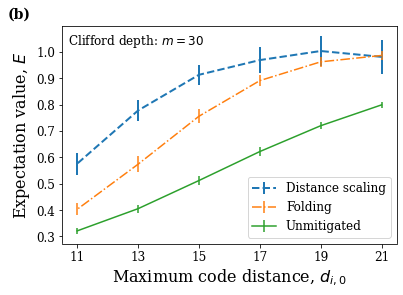

In [17]:
distance_indices = [[0, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6], [4, 5, 6, 7], [5, 6, 7, 8]]
ds_value_depth30_d21 = np.zeros((num_trials, 1)) 
ds_value_depth30_d19 = np.zeros((num_trials, 1))
ds_value_depth30_d17 = np.zeros((num_trials, 1))
ds_value_depth30_d15 = np.zeros((num_trials, 1))
ds_value_depth30_d13 = np.zeros((num_trials, 1))
ds_value_depth30_d11 = np.zeros((num_trials, 1))

distance_scale_factors = [gen_noise_model(p_err, d_array[d]) / gen_noise_model(p_err, d_array[distance_indices[0][0]]) for d in distance_indices[0]]

for trial in range(num_trials):

    ds_value_depth30_d21[trial] = distance_extrapolation(distance_scale_factors, [exp_vals_depth30_d21[trial, 0], exp_vals_depth30_d19[trial, 0], exp_vals_depth30_d17[trial, 0], exp_vals_depth30_d15[trial, 0]])
    ds_value_depth30_d19[trial] = distance_extrapolation(distance_scale_factors, [exp_vals_depth30_d19[trial, 0], exp_vals_depth30_d17[trial, 0], exp_vals_depth30_d15[trial, 0], exp_vals_depth30_d13[trial, 0]])
    ds_value_depth30_d17[trial] = distance_extrapolation(distance_scale_factors, [exp_vals_depth30_d17[trial, 0], exp_vals_depth30_d15[trial, 0], exp_vals_depth30_d13[trial, 0], exp_vals_depth30_d11[trial, 0]])
    ds_value_depth30_d15[trial] = distance_extrapolation(distance_scale_factors, [exp_vals_depth30_d15[trial, 0], exp_vals_depth30_d13[trial, 0], exp_vals_depth30_d11[trial, 0], exp_vals_depth30_d9[trial, 0]])
    ds_value_depth30_d13[trial] = distance_extrapolation(distance_scale_factors, [exp_vals_depth30_d13[trial, 0], exp_vals_depth30_d11[trial, 0], exp_vals_depth30_d9[trial, 0], exp_vals_depth30_d7[trial, 0]])
    ds_value_depth30_d11[trial] = distance_extrapolation(distance_scale_factors, [exp_vals_depth30_d11[trial, 0], exp_vals_depth30_d9[trial, 0], exp_vals_depth30_d7[trial, 0], exp_vals_depth30_d5[trial, 0]])


ds_mean_exp_val_depth30_d21 = np.mean(ds_value_depth30_d21)
ds_std_exp_val_depth30_d21 = np.std(ds_value_depth30_d21)
ds_error_depth30_d21 = ideal_values - ds_value_depth30_d21

ds_mean_exp_val_depth30_d19 = np.mean(ds_value_depth30_d19)
ds_std_exp_val_depth30_d19 = np.std(ds_value_depth30_d19)
ds_error_depth30_d19 = ideal_values - ds_value_depth30_d19

ds_mean_exp_val_depth30_d17 = np.mean(ds_value_depth30_d17)
ds_std_exp_val_depth30_d17 = np.std(ds_value_depth30_d17)
ds_error_depth30_d17 = ideal_values - ds_value_depth30_d17

ds_mean_exp_val_depth30_d15 = np.mean(ds_value_depth30_d15)
ds_std_exp_val_depth30_d15 = np.std(ds_value_depth30_d15)
ds_error_depth30_d15 = ideal_values - ds_value_depth30_d15

ds_mean_exp_val_depth30_d13 = np.mean(ds_value_depth30_d13)
ds_std_exp_val_depth30_d13 = np.std(ds_value_depth30_d13)
ds_error_depth30_d13 = ideal_values - ds_value_depth30_d13

ds_mean_exp_val_depth30_d11 = np.mean(ds_value_depth30_d11)
ds_std_exp_val_depth30_d11 = np.std(ds_value_depth30_d11)
ds_error_depth30_d11 = ideal_values - ds_value_depth30_d11

## Plot of expectation values for each set of distances
plt.errorbar(d_array[0:6], [ds_mean_exp_val_depth30_d21, ds_mean_exp_val_depth30_d19, ds_mean_exp_val_depth30_d17, ds_mean_exp_val_depth30_d15, ds_mean_exp_val_depth30_d13, ds_mean_exp_val_depth30_d11], yerr=[ds_std_exp_val_depth30_d21, ds_std_exp_val_depth30_d19, ds_std_exp_val_depth30_d17, ds_std_exp_val_depth30_d15, ds_std_exp_val_depth30_d13, ds_std_exp_val_depth30_d11], ls='--', label='Distance scaling', lw=2)
plt.errorbar(d_array[0:6], [folding_mean_exp_val_depth30_d21, folding_mean_exp_val_depth30_d19, folding_mean_exp_val_depth30_d17, folding_mean_exp_val_depth30_d15, folding_mean_exp_val_depth30_d13, folding_mean_exp_val_depth30_d11], yerr=[folding_std_exp_val_depth30_d21, folding_std_exp_val_depth30_d19, folding_std_exp_val_depth30_d17, folding_std_exp_val_depth30_d15, folding_std_exp_val_depth30_d13, folding_std_exp_val_depth30_d11], ls = '-.',label='Folding')
plt.errorbar(d_array[0:6], [np.mean(exp_vals_depth30_d21[:, 4]), np.mean(exp_vals_depth30_d19[:, 4]), np.mean(exp_vals_depth30_d17[:, 4]), np.mean(exp_vals_depth30_d15[:, 4]), np.mean(exp_vals_depth30_d13[:, 4]), np.mean(exp_vals_depth30_d11[:, 4])], yerr=[np.std(exp_vals_depth30_d21[:, 4]), np.std(exp_vals_depth30_d19[:, 4]), np.std(exp_vals_depth30_d17[:, 4]), np.std(exp_vals_depth30_d15[:, 4]), np.std(exp_vals_depth30_d13[:, 4]), np.std(exp_vals_depth30_d11[:, 4])], label='Unmitigated')

import matplotlib.font_manager as font_manager
font = font_manager.FontProperties(family='serif', style='normal', size=12)
plt.xlabel(r'Maximum code distance, $d_{i,0}$', family='serif', fontsize=16)
plt.ylabel(r'Expectation value, $E$', family='serif', fontsize=16)
plt.xticks(ticks = [11, 13, 15, 17, 19, 21], family='serif', fontsize=12)
plt.yticks(family='serif', fontsize=12)
plt.legend(loc='lower right', prop=font)
# plt.title(f'Expectation values at depth = {depth}, 100 trials')
plt.text(10.7, 1.03,'Clifford depth: $m = 30$', family='serif', fontsize=12)
plt.text(8.7, 1.13, "(b)", weight='bold', fontsize=14, family='serif')
plt.savefig("./ieee-quantum-week/ds_zne/depth_30_exp_vals.eps", format = 'eps', bbox_inches="tight")
plt.show()


/var/folders/mc/x5spc52d2nq_q5x2xpg3r77m0000gn/T/ipykernel_1282/3920024954.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.collections[0].colorbar.set_ticklabels(ticklabels=[0, 10, 20, 30, 40, 50], fontfamily="serif", fontsize=9)


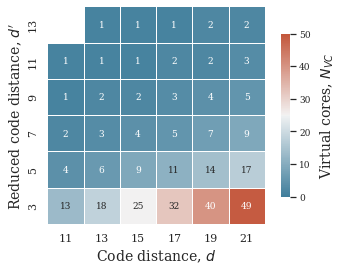

In [12]:
import seaborn as sns


sns.set_theme(style="white")


d = np.linspace(11, 21, 6, dtype=int)
d_prime = d - 8 * np.ones(len(d), dtype=int)
inv_d_prime_sq = 1 / (d_prime)**2

cores = np.floor(np.outer((d**2), (inv_d_prime_sq))).transpose()

# Generate a mask for the upper triangle
mask = np.zeros_like(cores, dtype=bool)

mask[-1, 0] = True


# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax = sns.heatmap(cores, cmap=cmap, mask=mask, vmin=0, vmax=50,
             square=True, linewidths=.5, cbar_kws={"shrink": .75}, annot=True, annot_kws={"fontfamily": "serif", "fontsize": 9})
ax.invert_yaxis()
ax.set_xticklabels(d, fontfamily="serif", fontsize=11)
ax.set_yticklabels(d_prime, fontfamily="serif", fontsize=11)
ax.set_xlabel(r"Code distance, $d$", fontfamily="serif", fontsize=14)
ax.set_ylabel(r"Reduced code distance, $d'$", fontfamily="serif", fontsize=14)
ax.collections[0].colorbar.set_label(r"Virtual cores, $N_{VC}$", fontfamily="serif", labelpad=8, fontsize=14)
ax.collections[0].colorbar.set_ticklabels(ticklabels=[0, 10, 20, 30, 40, 50], fontfamily="serif", fontsize=9)
plt.savefig("heatmap.eps", format = 'eps', bbox_inches="tight")


In [18]:
ds_vals20 = np.array([ds_mean_exp_val_depth20_d21, ds_mean_exp_val_depth20_d19, ds_mean_exp_val_depth20_d17, ds_mean_exp_val_depth20_d15, ds_mean_exp_val_depth20_d13, ds_mean_exp_val_depth20_d11]) 
unmitigated_vals20 = np.array([np.mean(exp_vals_depth20_d21[:, 4]), np.mean(exp_vals_depth20_d19[:, 4]), np.mean(exp_vals_depth20_d17[:, 4]), np.mean(exp_vals_depth20_d15[:, 4]), np.mean(exp_vals_depth20_d13[:, 4]), np.mean(exp_vals_depth20_d11[:, 4])])

In [19]:
folding_vals20 = np.array([folding_mean_exp_val_depth20_d21, folding_mean_exp_val_depth20_d19, folding_mean_exp_val_depth20_d17, folding_mean_exp_val_depth20_d15, folding_mean_exp_val_depth20_d13, folding_mean_exp_val_depth20_d11])

In [20]:
ds_error20 = np.abs(np.ones((len(ds_vals20))) - ds_vals20)
folding_error20 = np.abs(np.ones((len(folding_vals20))) - folding_vals20)

In [21]:
delta_error20 = ds_error20 - folding_error20
delta_error20

array([-0.00322708, -0.00693182, -0.03570561, -0.08058442, -0.15506858,
       -0.20554115])

In [22]:
np.divide(delta_error20, folding_error20)

array([-0.63672502, -0.63049885, -0.89229507, -0.71851742, -0.62718286,
       -0.47740719])

In [23]:
unmitigated_error20 = np.abs(np.ones(len(unmitigated_vals20))-unmitigated_vals20)
folding_improvement20 = np.divide((folding_error20 - unmitigated_error20), unmitigated_error20)
folding_improvement20

array([-0.96438885, -0.94576068, -0.85819087, -0.7052121 , -0.49613545,
       -0.27873276])

In [24]:
ds_improvement20 = np.divide((ds_error20 - unmitigated_error20), unmitigated_error20)
ds_improvement20

array([-0.98706336, -0.97995851, -0.98472646, -0.91702234, -0.81215066,
       -0.62307093])

In [25]:
ds_std20 = [ds_std_exp_val_depth20_d21, ds_std_exp_val_depth20_d19, ds_std_exp_val_depth20_d17, ds_std_exp_val_depth20_d15, ds_std_exp_val_depth20_d13, ds_std_exp_val_depth20_d11]
folding_std20 = [folding_std_exp_val_depth20_d21, folding_std_exp_val_depth20_d19, folding_std_exp_val_depth20_d17, folding_std_exp_val_depth20_d15, folding_std_exp_val_depth20_d13, folding_std_exp_val_depth20_d11]
unmitigated_std20 = [np.std(exp_vals_depth20_d21[:, 4]), np.std(exp_vals_depth20_d19[:, 4]), np.std(exp_vals_depth20_d17[:, 4]), np.std(exp_vals_depth20_d15[:, 4]), np.std(exp_vals_depth20_d13[:, 4]), np.std(exp_vals_depth20_d11[:, 4])]

100 * np.divide(np.array(ds_std20) - np.array(unmitigated_std20), np.array(unmitigated_std20))

array([404.75273569, 249.31201547, 162.68189409, 123.2825153 ,
        86.67656952, 154.77303404])

In [26]:
ds_std30 = [ds_std_exp_val_depth30_d21, ds_std_exp_val_depth30_d19, ds_std_exp_val_depth30_d17, ds_std_exp_val_depth30_d15, ds_std_exp_val_depth30_d13, ds_std_exp_val_depth30_d11]
folding_std30 = [folding_std_exp_val_depth30_d21, folding_std_exp_val_depth30_d19, folding_std_exp_val_depth30_d17, folding_std_exp_val_depth30_d15, folding_std_exp_val_depth30_d13, folding_std_exp_val_depth30_d11]
unmitigated_std30 = [np.std(exp_vals_depth30_d21[:, 4]), np.std(exp_vals_depth30_d19[:, 4]), np.std(exp_vals_depth30_d17[:, 4]), np.std(exp_vals_depth30_d15[:, 4]), np.std(exp_vals_depth30_d13[:, 4]), np.std(exp_vals_depth30_d11[:, 4])]

np.divide(np.array(ds_std30), np.array(unmitigated_std30))

array([6.14951561, 4.21976524, 2.93193864, 2.26273633, 2.77526713,
       4.02360993])

In [27]:
np.divide(np.array(ds_std30), np.array(folding_std30))

array([3.94143964, 3.18580168, 2.38881678, 1.37052001, 1.36678569,
       1.78978168])

In [28]:
np.divide(np.array(ds_std20), np.array(folding_std20))

array([3.64460008, 2.78640537, 2.99826351, 1.92079907, 1.24984931,
       1.26706423])

In [34]:
ds_vals30 = np.array([ds_mean_exp_val_depth30_d21, ds_mean_exp_val_depth30_d19, ds_mean_exp_val_depth30_d17, ds_mean_exp_val_depth30_d15, ds_mean_exp_val_depth30_d13, ds_mean_exp_val_depth30_d11]) 
unmitigated_vals30 = np.array([np.mean(exp_vals_depth30_d21[:, 4]), np.mean(exp_vals_depth30_d19[:, 4]), np.mean(exp_vals_depth30_d17[:, 4]), np.mean(exp_vals_depth30_d15[:, 4]), np.mean(exp_vals_depth30_d13[:, 4]), np.mean(exp_vals_depth30_d11[:, 4])])
folding_vals30 = np.array([folding_mean_exp_val_depth30_d21, folding_mean_exp_val_depth30_d19, folding_mean_exp_val_depth30_d17, folding_mean_exp_val_depth30_d15, folding_mean_exp_val_depth30_d13, folding_mean_exp_val_depth30_d11])
folding_error30 = np.abs(np.ones((len(folding_vals30))) - folding_vals30)
ds_error30 = np.abs(np.ones((len(ds_vals30))) - ds_vals30)
delta_error30 = ds_error30 - folding_error30
delta_error30

array([ 0.0052899 , -0.03468021, -0.07790229, -0.15739532, -0.20392586,
       -0.17341338])

In [35]:
np.divide(delta_error30, folding_error30)

array([ 0.38423437, -0.91576399, -0.71388533, -0.64382997, -0.47809254,
       -0.29015647])

In [39]:
unmitigated_error30 = np.abs(np.ones(len(unmitigated_vals30))-unmitigated_vals30)
folding_improvement30 = np.divide((folding_error30 - unmitigated_error30), unmitigated_error30)
folding_improvement30

array([-0.93158669, -0.86493771, -0.71164702, -0.49947208, -0.28342428,
       -0.12046068])

In [41]:
ds_improvement30 = np.divide((ds_error30 - unmitigated_error30), unmitigated_error30)
ds_improvement30

array([-0.90529994, -0.98862289, -0.91749798, -0.82172696, -0.62601379,
       -0.3756647 ])